# infusionDrug

Continuous infusions are documented here and are entered from the nursing flowsheet (either manually or interfaced from the hospital electronic health record system).

Infusion drugs entered directly into the source system (eCareManager) by clinicians must include the concentration of the drug being infused. This is done by entering the "drugAmount" and "volumeOfFluid" and this is independent of the amount being infused (drugRate or infusionRate). Interfaced values from source EMRs may not contain the concentration.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [6]:
patientunitstayid = 242380

In [8]:
query = query_schema + """
select *
from infusiondrug
where patientunitstayid = {}
order by infusionoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,patientunitstayid,infusiondrugid,infusionyear,infusiontime24,infusiontime,infusionoffset,drugname,drugrate,infusionrate,drugamount,volumeoffluid,patientweight
0,242380,2001050,2015,15:00:00,evening,59,Nitroglycerin (mcg/min),10,3,50,250,
1,242380,1953142,2015,15:00:00,evening,59,Heparin (units/hr),1000,20,25000,500,
2,242380,1951808,2015,18:00:00,night,239,Heparin (units/hr),1000,20,25000,500,
3,242380,1973839,2015,18:00:00,night,239,Nitroglycerin (mcg/min),20,6,50,250,
4,242380,1985551,2015,21:00:00,night,419,Heparin (units/hr),1000,20,25000,500,


Above we can see a patient is admitted on (or quickly administered after admission) two drugs: nitroglycerin and heparin. The `drugrate` contains the infusion rate (1000 units/hr for herparin, 10 mcg/min for nitroglycerin). Further, the `drugamount` and `volumeoffluid` likely indicate the contents of the bag holding the fluid: a 500 mL bag containing a total of 25,000 units for heparin, and a 250 mL bag containing a total of 50 mg of nitroglycerin (note the unit change between the rate/amount in the nitroglycerin bag).

Sometimes patient drugs are dosed by weight - in those cases, the `patientweight` column would be populated.

## Hospitals with data available

In [10]:
query = query_schema + """
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct d.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join infusiondrug d
  on pt.patientunitstayid = d.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
65,188,3601,3314,92.029992
184,420,4679,3134,66.980124
90,243,4243,2738,64.529814
134,338,4277,2533,59.223755
54,167,6092,2461,40.397242
119,281,2531,2244,88.660608
122,300,3617,1827,50.511474
121,283,2097,1805,86.075346
58,176,4328,1793,41.427911
98,252,3371,1539,45.654109


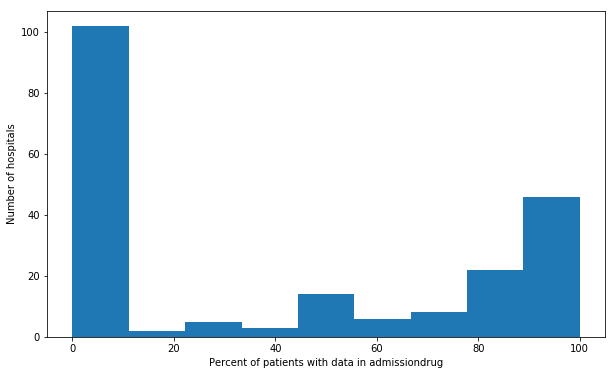

In [11]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in admissiondrug')
plt.ylabel('Number of hospitals')
plt.show()

As is common in eICU-CRD, there are a subset of hospitals who routinely utilize this portion of the medical record (and thus have high data completion), while there are other hospitals who rarely use this interface and thus have poor data completion.

The infusionDrug appears to be less frequently used, with over 100 hospitals having no data documented in the table. Conversely, over 40 hospitals have data in this table for all patients admitted.